In [1]:
import sys
import math
import numpy as np
from random import getrandbits,uniform,random,randint
from matplotlib import pyplot as plt

In [10]:
class Genetic:
    def __init__(self, target_func=lambda x: -x + 10*math.sin(2*x) + 7*math.cos(4*x), 
                 interval=[0, 10], deciml_digits=6, chrmsome_size=20,cross_prob=0.7,mutate_prob=0.7,iter_round=100,
                  mutate_percentage=0.2
                 ):    
        self.chrmsome_size = chrmsome_size  # 染色体条数
        self.target_func = target_func  # 要求解的目标函数
        self.interval = interval  # 取值区间
        self.deciml_digits = deciml_digits  # 要求精确到的小数点后位数
        
        self.iter_round = iter_round # 迭代进化次数
        self.chrmsome_code_length = self.determ_code_length()  # 确定编码长度（这里采用2进制编码）
        self.cross_prob = cross_prob  # 交叉概率，即能产生新后代的概率
        self.mutate_prob = mutate_prob  # 染色体变异概率
        self.mutate_percentage = mutate_percentage  # 染色体基因变异比例
        
        self.mean_fitness_iter = []
        self.best_fitness_iter = []
        self.best_solution_iter = []
        self.best_solutionfuncval_iter = []
        self.refer_solution = 0
        
        self.individual_list = [self.encode() for _ in range(self.chrmsome_size)]  # 种群染色体集合
        self.individual_fitness_list = self.evaluate_fitness(self.individual_list)  # 计算种群中所有个体初始的适应度

        self.new_individual_list = []  # 新一代染色体集合
        self.new_individual_fitness_list = []  # 新一代染色体适应度集合
        
        self.best_chrmsome = self.individual_list[np.argmax(self.individual_fitness_list)]  # 最优染色体
        self.best_solution = self.decode(self.best_chrmsome)  # 最优解
        self.best_fitness = self.individual_fitness_list.max()  # 最优解的适应度
  
    # 绘制图片并且返回解析真实解   
    def plot_val(self,pic_save_dir):  
        lin_space = 1/pow(10, self.deciml_digits)
        num_space = round((self.interval[1] - self.interval[0])/lin_space)
        x = [round(self.interval[0] + i*lin_space, self.deciml_digits) for i in range(num_space+1)]
        y = [self.target_func(argment) for argment in x]
        plt.plot(x, y)
        plt.title('function val distribution')
        plt.xlabel('variable x')
        plt.ylabel('function value y')
        plt.savefig(pic_save_dir + r'\\' + '真实解分布图.png')
        plt.show()
        arr_y = np.array(y)
        return x[arr_y.argmax()],arr_y.max()
 
    #  绘图显示平均适应度、最优适应度、最优解和最优解对应的函数值随迭代而变化
    def plot_iter(self, pic_save_dir):
        x = [iter_i for iter_i in range(1,len(self.mean_fitness_iter)+1)]
        y_list = [self.mean_fitness_iter, self.best_fitness_iter, 
                  self.best_solution_iter,self.best_solutionfuncval_iter]
        y_lable_list = ['mean_fitness','best_fitness','best_solution','best_solution_funcval']
        for y_index in range(len(y_list)):
            plt.plot(x, y_list[y_index],label=y_lable_list[y_index])
            plt.title('Genetic ' + y_lable_list[y_index])
            plt.xlabel(r'iter_round')
            plt.ylabel(y_lable_list[y_index])
            plt.savefig(pic_save_dir + r'\\' + y_lable_list[y_index] + '.png')
            plt.show()
  
    #通过小数点位数和解区间计算每条染色体的编码长度(2进制编码) 
    def determ_code_length(self):
        sub_interval = (self.interval[1] - self.interval[0])*pow(10, self.deciml_digits)
        for c_length in range(sys.maxsize):
            if pow(2, c_length-1) <= sub_interval < pow(2, c_length):
                return c_length
    
    # 编码成二进制染色体
    def encode(self):  
        while True:
            res = getrandbits(self.chrmsome_code_length)
            if self.interval[0] <= self.decode(res) <= self.interval[1]:
                return res
    
    # 将二进制染色体解码成实数解
    def decode(self, chromosome):  
        return round(self.interval[0] + chromosome*(self.interval[1] - self.interval[0])/(pow(2, self.chrmsome_code_length)-1),self.deciml_digits)
    
    # 输入染色体计算函数值
    def cal_func(self, chromosome):  
        val = self.decode(chromosome)
        return self.target_func(val)
    
    # sigmoid适应度函数
    def sigmoid(self, val):
        return 1/(1 + np.exp(-val))
    
    # 评估所有染色体个体的适应度(将染色体解码计算的函数值进行sigmoid转换)
    def evaluate_fitness(self, chrmsome_list):  
        val_list = np.array([self.sigmoid(self.cal_func(each_chrmsome)) for each_chrmsome in chrmsome_list])
        return val_list
    
     # 轮盘对赌选择
    def roulette_selection(self, fitness_list): 
        val_list = fitness_list + np.abs(fitness_list.min())
        sumFits = val_list.sum()
        rndPoint = uniform(0, sumFits)
        accumulator = 0.0
        for ind, val in enumerate(val_list):
            accumulator += val
            if accumulator >= rndPoint:
                return ind
    
    #  交叉过程 
    def cross(self, chrom1, chrom2): 
        p = random()  # 随机概率
        n = 2 ** self.chrmsome_code_length - 1
        if chrom1 != chrom2 and p < self.cross_prob:
            t = randint(1, self.chrmsome_code_length - 1)  # 随机选择一点（单点交叉）
            mask = n << t  # << 左移运算符
            (l1, l2) = (chrom1 & mask, chrom2 & mask)  # & 按位与运算符：参与运算的两个值,如果两个相应位都为1,则该位的结果为1,否则为0
            mask = n >> (self.chrmsome_code_length - t)
            (r1, r2) = (chrom1 & mask, chrom2 & mask)
            (chrom1, chrom2) = (r1 + l2, r2 + l1)
        return chrom1, chrom2
    
    # 变异
    def mutate(self, chrom): 
        mutate_round = 0
        while mutate_round < round(self.chrmsome_code_length*self.mutate_prob):
            p = random()
            if p < self.mutate_prob:
                t = randint(1, self.chrmsome_code_length)
                mask1 = 1 << (t - 1)
                mask2 = chrom & mask1
                if mask2 > 0:
                    chrom = chrom & (~mask2)  # ~ 按位取反运算符：对数据的每个二进制位取反,即把1变为0,把0变为1
                else:
                    chrom = chrom ^ mask1  # ^ 按位异或运算符：当两对应的二进位相异时，结果为1
            mutate_round += 1
        return chrom
    
    # 更新最优染色体
    def refresh_best_chromosome(self):  
        best_index = np.argmax(self.individual_fitness_list)
        self.best_chrmsome = self.individual_list[best_index]
        self.best_fitness = self.individual_fitness_list[best_index]
        self.best_solution = self.decode(self.best_chrmsome)
      
    # 自然选择过程      
    def natural_select(self):
        range_len = len(self.new_individual_list)
        for _ in range(range_len):
            # 找到新子代中适应度最高的染色体 index
            newindividual_highest_fitness_index = np.argmax(self.new_individual_fitness_list)
            # 找到旧种群中适应度最低的染色体 index
            individual_lowest_fitness_index = np.argmin(self.individual_fitness_list)
            if self.new_individual_fitness_list[newindividual_highest_fitness_index] > self.individual_fitness_list[individual_lowest_fitness_index]:
                # 个体替代
                self.individual_list[individual_lowest_fitness_index] = self.new_individual_list[newindividual_highest_fitness_index]
                self.individual_fitness_list[individual_lowest_fitness_index] = self.new_individual_fitness_list[newindividual_highest_fitness_index]
                # 删除新子代中适应度最高的染色体
                self.new_individual_fitness_list = np.delete(self.new_individual_fitness_list, newindividual_highest_fitness_index,axis=0)
                self.new_individual_list.pop(newindividual_highest_fitness_index)
            else:
                break
        return
    
    # 进行一次进化过程,假设有m个初始个体集合，每次取出两个进行杂交变异产生新种群，
    # 循环m/2次就认为完成了一次生产，然后按适应度进行优胜劣汰后认为完成了一次进化
    def evolve(self):  
        pos_generate = 0
        # 初始化子代种群染色体集合
        self.new_individual_list = []
        self.new_individual_fitness_list = []
        while True:
            # 选择两个个体
            chrosome_p1 = self.roulette_selection(self.individual_fitness_list)
            chrosome_p2 = self.roulette_selection(self.individual_fitness_list)
            # 进行杂交
            new_individual_p1,new_individual_p2 = self.cross(chrosome_p1,chrosome_p2)
            # 变异
            new_individual_p1 = self.mutate(new_individual_p1)
            new_individual_p2 = self.mutate(new_individual_p2)
            # 存放在新个体集合中
            self.new_individual_list.extend([new_individual_p1, new_individual_p2])
            if pos_generate > self.chrmsome_size/2:
                break
            pos_generate += 2
        
        # 计算子代染色体适应度
        self.new_individual_fitness_list = self.evaluate_fitness(self.new_individual_list)
        # 更新换代，用新子代最好的去替代旧种群中最差的
        self.natural_select()
        # 更新全局最优个体
        self.refresh_best_chromosome()
    
    # 记录迭代过程
    def iter_record(self):
        self.mean_fitness_iter.append(self.individual_fitness_list.mean())
        self.best_fitness_iter.append(self.best_fitness)
        self.best_solution_iter.append(self.best_solution)
        self.best_solutionfuncval_iter.append(self.target_func(self.best_solution))
    
    # 主运行程序
    def genetic_engine(self,pic_save_dir):  # 完成算法运行的所有进化过程，遗传算法的运行引擎
        iter_count = 0
        while iter_count < self.iter_round:
            # 一次进化
            self.evolve()
            # 记录迭代结果
            self.iter_record()
            iter_count += 1
        # 参考解
        self.refer_solution = self.plot_val(pic_save_dir)  
        
        print('The Reference Solution:',(self.refer_solution[0], self.refer_solution[1]))
        print('Genetic Algorithm:')
        print('best solution fitness of x:', self.best_fitness)
        print('best solution of x:', self.best_solution)
        print('best function val of x:', self.target_func(self.best_solution))
        return self.plot_iter(pic_save_dir)

In [11]:
target_func = lambda x: -(x+2)*(x+1)*(x-3)*(x-4)
pic_save_dir = r'D:\WORK__wells\Other Program\Function Solution'

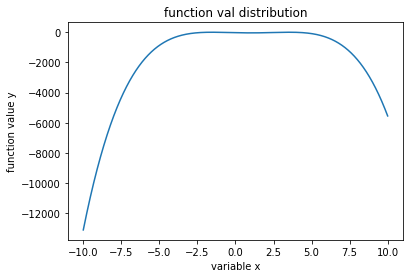

The Reference Solution: (-1.55, 6.24999375)
Genetic Algorithm:
best solution fitness of x: 0.9980731542304722
best solution of x: -1.551
best function val of x: 6.249942224799001


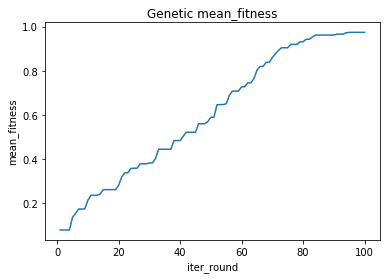

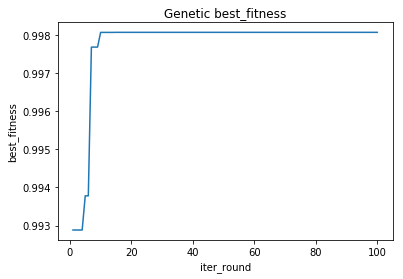

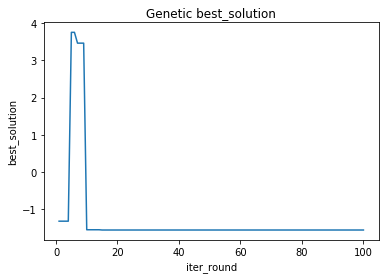

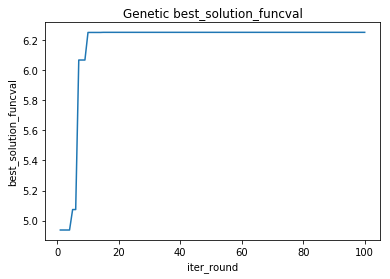

In [12]:
genetic_algorythm = Genetic(target_func= target_func,interval=[-10,10],chrmsome_size=50,
                         deciml_digits=3,cross_prob=0.5,mutate_prob=0.5,
                         iter_round=100)
genetic_algorythm.genetic_engine(pic_save_dir)
